In [1]:
import os

# set current file as the working directory
# os.chdir(os.path.dirname(os.path.abspath(__file__)))

from scipy import stats

import tensorflow as tf

# from model import Model
import numpy as np
from keras.utils import to_categorical  

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import argparse
import pickle
# from helper.stats import stats_dataset
# from helper.utils import pickle_store_dataset,load_from_pickle
import time 
import tensorflow as tf
import concurrent.futures
import torch
import sys
from vit_pytorch import SimpleViT

2024-04-01 15:19:01.489093: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-01 15:19:01.538858: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-01 15:19:02.445466: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
data_dir = './data'
def load_pickle(file_name):
    with open(f'{data_dir}/{file_name}', 'rb') as f:
        return pickle.load(f)

# Use concurrent.futures to load the data in parallel
with concurrent.futures.ThreadPoolExecutor(max_workers=70) as executor:
    train_data_future = executor.submit(load_pickle, 'train_data.pkl')
    train_labels_future = executor.submit(load_pickle, 'train_labels.pkl')
    test_data_future = executor.submit(load_pickle, 'test_data.pkl')
    test_labels_future = executor.submit(load_pickle, 'test_labels.pkl')
    val_data_future = executor.submit(load_pickle, 'val_data.pkl')
    val_labels_future = executor.submit(load_pickle, 'val_labels.pkl')

    # Wait for all futures to complete
    train_data = train_data_future.result()
    train_labels = train_labels_future.result()
    test_data = test_data_future.result()
    test_labels = test_labels_future.result()
    val_data = val_data_future.result()
    val_labels = val_labels_future.result()

In [3]:
def convert_to_int(array):
    return (np.sum(array) + 1)


def create_patches(images, patch_size):
    assert 256 % patch_size == 0, "patch_size should divide 256 evenly"
    num_patches_per_image = (images.shape[1] // patch_size) * (images.shape[2] // patch_size)
    num_images = images.shape[0]
    
    # Predefine numpy arrays
    all_patches = np.empty((num_images, num_patches_per_image), dtype=int)
    
    for image_index, image in enumerate(images):
        patch_index = 0
        for i in range(0, image.shape[0], patch_size):
            for j in range(0, image.shape[1], patch_size):
                patch = image[i:i+patch_size, j:j+patch_size, :]
                flattened_patch = patch.flatten()
                int_patch = convert_to_int(flattened_patch)  # convert to int
                all_patches[image_index, patch_index] = int_patch  # store the integer patch
                patch_index += 1
                
    return all_patches


In [4]:
patch_size = 16
vocab_size = 255*3*(patch_size)**2 + 2
embedding_dim = 16
max_length = (256//patch_size) ** 2 
num_classes = 43

In [5]:
train_data_patches = create_patches(train_data, patch_size)
val_data_patches = create_patches(val_data, patch_size)
test_data_patches = create_patches(test_data, patch_size)


In [6]:
train_labels = to_categorical(train_labels, num_classes)
val_labels = to_categorical(val_labels, num_classes)

In [22]:
print(train_labels.shape)
print(val_labels.shape)
print(test_labels.shape)

(61201, 43)
(8743, 43)
(17486,)


/home/sukhmeet/miniconda3/envs/tf2/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_7 (Embedding)         │ (None, 256, 16)        │     3,133,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 32)             │       131,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 43)             │         2,795 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,269,483 (12.47 MB)

 Trainable params: 3,269,483 (12.47 MB)

 Non-trainable params: 0 (0.00 B)

None


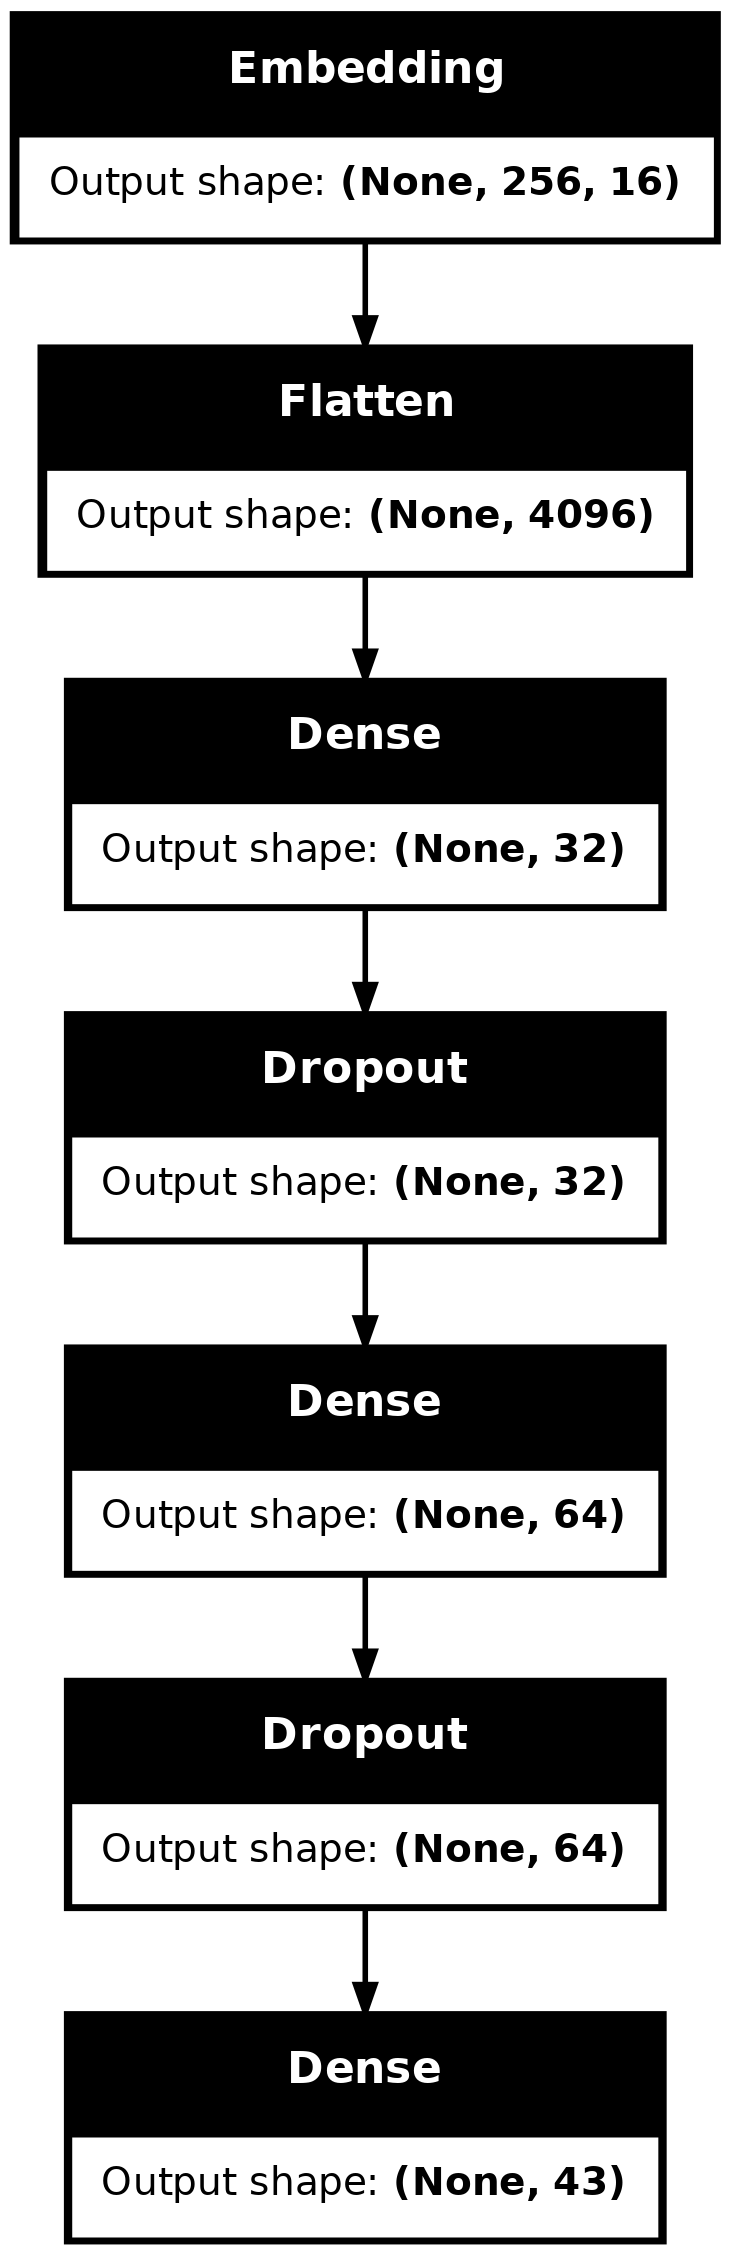

In [64]:
from tensorflow.keras import regularizers
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_shape=(max_length,)),
    # tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

# Add EarlyStopping
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

# history = model.fit(train_data, train_labels, epochs=num_epochs, validation_data=(val_data, val_labels), callbacks=[callback])

print(model.summary())

#plot the model
tf.keras.utils.plot_model(model, to_file='model.png', show_shapes=True)

In [65]:
num_epochs = 30
batch_size = 32
history = model.fit(train_data_patches, train_labels, epochs=num_epochs, validation_data=(val_data_patches, val_labels), verbose=2,batch_size=batch_size)
# history = model.fit(train_data, train_labels, epochs=num_epochs, validation_data=(val_data, val_labels),batch_size=batch_size, callbacks=[callback],verbose=2)
#

Epoch 1/30
1913/1913 - 24s - 13ms/step - accuracy: 0.3928 - loss: 2.5786 - val_accuracy: 0.4909 - val_loss: 2.2492
Epoch 2/30
1913/1913 - 21s - 11ms/step - accuracy: 0.5148 - loss: 2.1524 - val_accuracy: 0.5300 - val_loss: 2.1569
Epoch 3/30
1913/1913 - 21s - 11ms/step - accuracy: 0.5881 - loss: 1.9257 - val_accuracy: 0.5335 - val_loss: 2.2136
Epoch 4/30
1913/1913 - 21s - 11ms/step - accuracy: 0.6486 - loss: 1.7130 - val_accuracy: 0.5297 - val_loss: 2.3629
Epoch 5/30


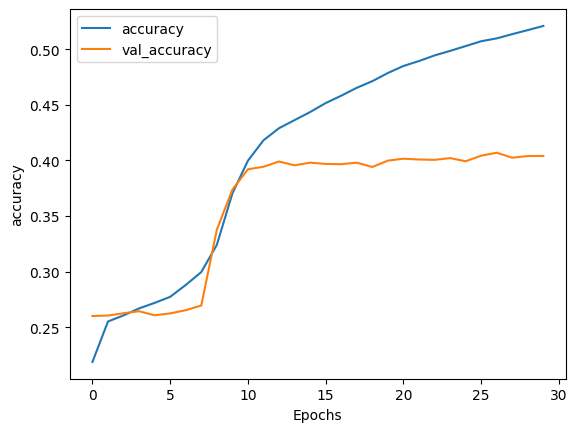

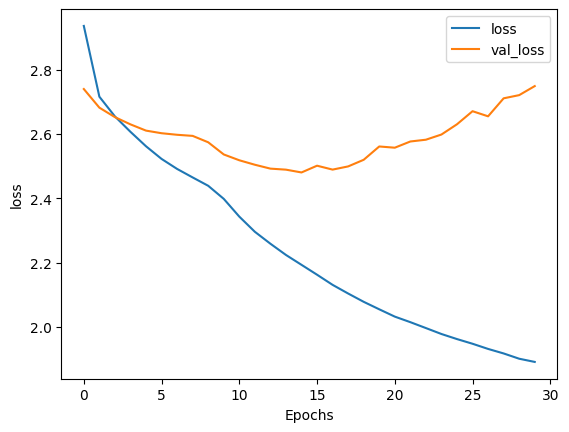

In [ ]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")



In [ ]:
y_pred = model.predict(test_data_patches)
y_pred = np.argmax(y_pred, axis=1)

547/547 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

f1 = f1_score(test_labels, y_pred, average='weighted')
print(f"F1 Score: {f1}")

F1 Score: 0.3180928432396064


In [ ]:
accuracy = accuracy_score(test_labels, y_pred)
print(f"Accuracy: {accuracy}")
print(classification_report(test_labels, y_pred))

Accuracy: 0.40152121697357884
              precision    recall  f1-score   support

           0       0.44      0.68      0.54      3491
           1       0.00      0.00      0.00        59
           2       0.00      0.00      0.00        67
           3       0.00      0.00      0.00       530
           4       0.14      0.08      0.10       501
           5       0.00      0.00      0.00       167
           6       0.00      0.00      0.00        55
           7       0.00      0.00      0.00        31
           8       0.00      0.00      0.00       121
           9       0.00      0.00      0.00       221
          10       0.00      0.00      0.00        22
          11       0.00      0.00      0.00        53
          12       0.64      0.04      0.08       573
          13       0.00      0.00      0.00        74
          14       0.69      0.80      0.74       999
          15       0.00      0.00      0.00       119
          16       0.76      0.71      0.73      11

/home/sukhmeet/miniconda3/envs/tf2/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sukhmeet/miniconda3/envs/tf2/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sukhmeet/miniconda3/envs/tf2/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitaliz

In [ ]:
accuracy = accuracy_score(test_labels, y_pred)
print(f"Accuracy: {accuracy}")
print(classification_report(test_labels, y_pred))

Accuracy: 0.40152121697357884
              precision    recall  f1-score   support

           0       0.44      0.68      0.54      3491
           1       0.00      0.00      0.00        59
           2       0.00      0.00      0.00        67
           3       0.00      0.00      0.00       530
           4       0.14      0.08      0.10       501
           5       0.00      0.00      0.00       167
           6       0.00      0.00      0.00        55
           7       0.00      0.00      0.00        31
           8       0.00      0.00      0.00       121
           9       0.00      0.00      0.00       221
          10       0.00      0.00      0.00        22
          11       0.00      0.00      0.00        53
          12       0.64      0.04      0.08       573
          13       0.00      0.00      0.00        74
          14       0.69      0.80      0.74       999
          15       0.00      0.00      0.00       119
          16       0.76      0.71      0.73      11

/home/sukhmeet/miniconda3/envs/tf2/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sukhmeet/miniconda3/envs/tf2/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sukhmeet/miniconda3/envs/tf2/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitaliz